## Train ResNets

### created by Yuying Liu, 04/30/2020

This script is a template for training neural network time-steppers for different systems and different time scales. To reproduce the results in the paper, one needs to obtain all 11 neural network models for each nonlinear system under study. For setup details, please refer to Table 2 in the paper.

In [61]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [3]:
# adjustables

k = 2                        # model index: should be in {0, 2, ..., 10}
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'Hyperbolic'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epoch = 100000            # the maximum training epoch 
batch_size = 320              # training batch size
arch = [2, 128, 128, 128, 2]  # architecture of the neural network

In [4]:
# paths
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
n_forward = 5
step_size = 2**k

In [51]:

class DataSet:
    def __init__(self, train_data, val_data, test_data, dt, step_size, n_forward):
        """
        :param train_data: array of shape n_train x train_steps x input_dim
                            where train_steps = max_step x (n_steps + 1)
        :param val_data: array of shape n_val x val_steps x input_dim
        :param test_data: array of shape n_test x test_steps x input_dim
        :param dt: the unit time step
        :param step_size: an integer indicating the step sizes
        :param n_forward: number of steps forward
        """
        n_train, train_steps, n_dim = train_data.shape
        n_val, val_steps, _ = val_data.shape
        n_test, test_steps, _ = test_data.shape
        assert step_size*n_forward+1 <= train_steps and step_size*n_forward+1 <= val_steps

        # params
        self.dt = dt
        self.n_dim = n_dim
        self.step_size = step_size
        self.n_forward = n_forward
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = n_test

        # device
        self.device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

        # data
        x_idx = 0
        y_start_idx = x_idx #+1#+ step_size
        y_end_idx = x_idx +n_forward+1#+ step_size*n_forward + 1
        self.train_x = torch.tensor(train_data[:, x_idx, :], requires_grad=True).float().to(self.device)
        self.train_ys = torch.tensor(train_data[:, y_start_idx:y_end_idx:, :]).float().to(self.device)
        self.train_ys = self.train_ys[:,[4, 5, 6, 7, 8, 9, 10, 11, 12]]
        
        self.val_x = torch.tensor(val_data[:, x_idx, :], requires_grad=True).float().to(self.device)
        self.val_ys = torch.tensor(val_data[:, y_start_idx:y_end_idx:, :]).float().to(self.device)
        self.val_ys = self.val_ys[:,[4, 5, 6, 7, 8, 9, 10, 11, 12]]
        
        self.test_x = torch.tensor(test_data[:, 0, :], requires_grad=True).float().to(self.device)
        self.test_ys = torch.tensor(test_data[:, 1:, :]).float().to(self.device)


In [52]:
# load data
train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]

# create dataset object
n_forward=12
dataset = DataSet(train_data, val_data, test_data, dt, step_size, n_forward)

In [53]:
dataset.train_ys.shape

torch.Size([1600, 9, 2])

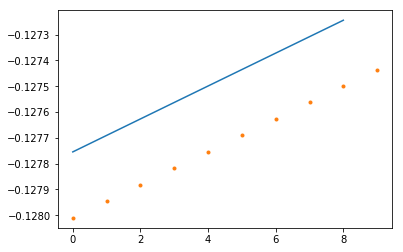

In [54]:
plt.plot(dataset.train_ys[0,:,0].cpu().numpy())
plt.plot(train_data[0,0:10,0], '.')
# plt.show()



In [65]:
#Resnet.py 

import torch
import numpy as np
import scipy.interpolate
from utils import DataSet


class NNBlock(torch.nn.Module):
    def __init__(self, arch, activation=torch.nn.ReLU()):
        """
        :param arch: architecture of the nn_block
        :param activation: activation function
        """
        super(NNBlock, self).__init__()

        # param
        self.n_layers = len(arch)-1
        self.activation = activation
        self.device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

        # network arch
        for i in range(self.n_layers):
            self.add_module('Linear_{}'.format(i), torch.nn.Linear(arch[i], arch[i+1]).to(self.device))

    def forward(self, x):
        """
        :param x: input of nn
        :return: output of nn
        """
        for i in range(self.n_layers - 1):
            x = self.activation(self._modules['Linear_{}'.format(i)](x))
        # no nonlinear activations in the last layer
        x = self._modules['Linear_{}'.format(self.n_layers - 1)](x)
        return x


class ResNet(torch.nn.Module):
    def __init__(self, arch, dt, step_size, prev_models, activation=torch.nn.ReLU()):
        """
        :param arch: a list that provides the architecture
        :param dt: time step unit
        :param step_size: forward step size
        :param activation: activation function in neural network
        """
        super(ResNet, self).__init__()

        # check consistencies
        assert isinstance(arch, list)
        assert arch[0] == arch[-1]

        # param
        self.n_dim = arch[0]

        # data
        self.dt = dt
        self.step_size = step_size

        # device
        self.device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

        # layer
        self.activation = activation
        self.add_module('increment', NNBlock(arch, activation=activation))
        
        # sort models by their step sizes (increasing order)
        step_sizes = [model.step_size for model in prev_models]
        models = [model for _, model in sorted(zip(step_sizes, prev_models), reverse=False)]
    
        self.prev_models = models
        
    def check_data_info(self, dataset):
        """
        :param: dataset: a dataset object
        :return: None
        """
        assert self.n_dim == dataset.n_dim
        assert self.dt == dataset.dt
        assert self.step_size == dataset.step_size

    def forward(self, x_init):
        """
        :param x_init: array of shape batch_size x input_dim
        :return: next step prediction of shape batch_size x input_dim
        """
        return x_init + self._modules['increment'](x_init)

    def uni_scale_forecast(self, x_init, n_steps):
        """
        :param x_init: array of shape n_test x input_dim
        :param n_steps: number of steps forward in terms of dt
        :return: predictions of shape n_test x n_steps x input_dim and the steps
        """
        steps = list()
        preds = list()
        sample_steps = range(n_steps)

        # forward predictions
        x_prev = x_init
        cur_step = self.step_size - 1
        while cur_step < n_steps + self.step_size:
            x_next = self.forward(x_prev)
            steps.append(cur_step)
            preds.append(x_next)
            cur_step += self.step_size
            x_prev = x_next

        # include the initial frame
        steps.insert(0, 0)
        preds.insert(0, torch.tensor(x_init).float().to(self.device))

        # interpolations
        preds = torch.stack(preds, 2).detach().numpy()
        cs = scipy.interpolate.interp1d(steps, preds, kind='linear')
        y_preds = torch.tensor(cs(sample_steps)).transpose(1, 2).float()

        return y_preds

    def train_net(self, dataset, max_epoch, batch_size, w=1.0, lr=1e-3, model_path=None):
        """
        :param dataset: a dataset object
        :param max_epoch: maximum number of epochs
        :param batch_size: batch size
        :param w: l2 error weight
        :param lr: learning rate
        :param model_path: path to save the model
        :return: None
        """
        # check consistency
        self.check_data_info(dataset)

        # training
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        epoch = 0
        best_loss = 1e+5
        start_time = time.time()
        while epoch < max_epoch:
            epoch += 1
            # ================= prepare data ==================
            n_samples = dataset.n_train
            new_idxs = torch.randperm(n_samples)
            batch_x = dataset.train_x[new_idxs[:batch_size], :].to(self.device)
            batch_ys = dataset.train_ys[new_idxs[:batch_size], :, :].to(self.device)
            # =============== calculate losses ================
            train_loss = self.calculate_loss(batch_x, batch_ys, w=w)
            val_loss = self.calculate_loss(dataset.val_x, dataset.val_ys, w=w)
            # ================ early stopping =================
            if best_loss <= 1e-8:
                print('--> model has reached an accuracy of 1e-8! Finished training!')
                break
            # =================== backward ====================
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            # =================== log =========================
            if epoch == 10:
                    end_time = time.time()
                    print("time for first 10 = ", end_time - start_time)
                    
            if epoch % 100 == 0:
                
                print('epoch {}, training loss {}, validation loss {}'.format(epoch, train_loss.item(),
                                                                              val_loss.item()))
                if val_loss.item() < best_loss:
                    best_loss = val_loss.item()
                    if model_path is not None:
                        print('(--> new model saved @ epoch {})'.format(epoch))
                        torch.save(self, model_path)

        # if to save at the end
        if val_loss.item() < best_loss and model_path is not None:
            print('--> new model saved @ epoch {}'.format(epoch))
            torch.save(self, model_path)

    def calculate_loss(self, x, ys, w=1.0):
        """
        :param x: x batch, array of size batch_size x n_dim
        :param ys: ys batch, array of size batch_size x n_steps x n_dim
        :return: overall loss
        """
        torch.autograd.set_detect_anomaly(True)
        batch_size, n_steps, n_dim = ys.size()
        assert n_dim == self.n_dim
        
        #we want to get next 10 timesteps 
        #smallest is dt = 1
        #middle is dt = 2
        #this one is dt = 4
        n_steps = 9
        y_preds = torch.zeros(batch_size, n_steps, n_dim).float().to(self.device)
        
        pred_big = self.forward(x)
        #first step we care about is after 1 big step
        y_preds[:,0,:] = pred_big
        
        #next step is big plus little
        y_preds[:,1,:] = self.prev_models[0](pred_big)
        
        #next step is big plus mid
        pred_mid = self.prev_models[1](pred_big)
        y_preds[:,2,:] = pred_mid
        
        #next is big, mid, small
        y_preds[:,3,:] = self.prev_models[0](pred_mid)
        
        #last is two big 
        pred_big = self.forward(pred_big)
        y_preds[:,4,:] = pred_big
        
        #2 big, small 
        y_preds[:,5,:] =  self.prev_models[0](pred_big)
        
        #2 big, mid 
        pred_mid = self.prev_models[1](pred_big)
        y_preds[:,6,:] = pred_mid
        
        #2 big, mid, small  
        y_preds[:,7,:] =  self.prev_models[0](pred_mid)
        
        #3 big, mid, small  
        y_preds[:,8,:] =  self.forward(pred_big)
        
        
        # compute loss
        criterion = torch.nn.MSELoss(reduction='none')
        loss = w * criterion(y_preds, ys).mean() + (1-w) * criterion(y_preds, ys).max()
        
        return loss



def vectorized_multi_scale_forecast(x_init, n_steps, models):
    """
    :param x_init: initial state torch array of shape n_test x n_dim
    :param n_steps: number of steps forward in terms of dt
    :param models: a list of models
    :return: a torch array of size n_test x n_steps x n_dim,
             a list of indices that are not achieved by interpolations
    """
    
    # sort models by their step sizes (decreasing order)
    step_sizes = [model.step_size for model in models]
    models = [model for _, model in sorted(zip(step_sizes, models), reverse=True)]

    # we assume models are sorted by their step sizes (decreasing order)
    n_test, n_dim = x_init.shape
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    indices = list()
    extended_n_steps = n_steps + models[0].step_size
    preds = torch.zeros(n_test, extended_n_steps + 1, n_dim,requires_grad=True).float().to(device)

    # vectorized simulation
    indices.append(0)
    print(x_init.requires_grad)
    print(preds.requires_grad)
    preds[:, 0, :] = x_init
    print(preds.requires_grad)
    total_step_sizes = n_steps
    for model in models:
        n_forward = int(total_step_sizes/model.step_size)
        y_prev = preds[:, indices, :].reshape(-1, n_dim)
        indices_lists = [indices]
        for t in range(n_forward):
            y_next = model(y_prev.to(device)).to(device)
            shifted_indices = [x + (t + 1) * model.step_size for x in indices]
            indices_lists.append(shifted_indices)
            preds[:, shifted_indices, :] = y_next.reshape(n_test, -1, n_dim)
            y_prev = y_next
        indices = [val for tup in zip(*indices_lists) for val in tup]
        total_step_sizes = model.step_size - 1

    # simulate the tails
    last_idx = indices[-1]
    y_prev = preds[:, last_idx, :]
    while last_idx < n_steps:
        last_idx += models[-1].step_size
        y_next = models[-1](y_prev)
        preds[:, last_idx, :] = y_next
        indices.append(last_idx)
        y_prev = y_next

    # interpolations
    sample_steps = range(1, n_steps+1)
    valid_preds = preds[:, indices, :].detach().numpy()
    cs = scipy.interpolate.interp1d(indices, valid_preds, kind='linear', axis=1)
    y_preds = torch.tensor(cs(sample_steps)).float()

    return y_preds

In [66]:
prev_step_sizes = [1,2]
prev_models = list()
for s in prev_step_sizes:
    print('load model_D{}.pt'.format(s))
    prev_models.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0.pt'.format(s)), map_location='cpu'))
    
# fix model consistencies trained on gpus (optional)
for model in prev_models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load model_D1.pt
load model_D2.pt


In [67]:
model_name = 'model_D{}_noise{}_depends_bigger.pt'.format(step_size, noise)

# create/load model object
try:
    hj
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    model = torch.load(os.path.join(model_dir, model_name), map_location=device)
    model.device = device
except:
    print('create model {} ...'.format(model_name))
    model = ResNet(arch=arch, dt=dt, step_size=step_size, prev_models=prev_models)

# training
model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr,
                model_path=os.path.join(model_dir, model_name))

create model model_D4_noise0.0_depends_bigger.pt ...
time for first 10 =  3.324402332305908
epoch 100, training loss 2.0919551388942637e-06, validation loss 2.1116129573783837e-06
(--> new model saved @ epoch 100)
epoch 200, training loss 7.523656222474528e-07, validation loss 8.104712492240651e-07
(--> new model saved @ epoch 200)
epoch 300, training loss 4.53199021421824e-07, validation loss 5.306944217409182e-07
(--> new model saved @ epoch 300)
epoch 400, training loss 3.484232138362131e-07, validation loss 3.9370607396449486e-07
(--> new model saved @ epoch 400)
epoch 500, training loss 2.7906358468499093e-07, validation loss 3.078425265812257e-07
(--> new model saved @ epoch 500)
epoch 600, training loss 2.5030732331288164e-07, validation loss 3.011306830558169e-07
(--> new model saved @ epoch 600)
epoch 700, training loss 1.9917396798518894e-07, validation loss 2.1315234732810495e-07
(--> new model saved @ epoch 700)
epoch 800, training loss 1.8207393281954865e-07, validation lo

epoch 8700, training loss 1.1769951697715442e-06, validation loss 1.2046558595102397e-06
epoch 8800, training loss 9.900531239281918e-08, validation loss 1.057719813957192e-07
epoch 8900, training loss 1.356753273284994e-06, validation loss 1.617894440641976e-06
epoch 9000, training loss 5.1677332635335915e-08, validation loss 6.323395496110606e-08
epoch 9100, training loss 6.749473158151886e-08, validation loss 8.157485353876837e-08
epoch 9200, training loss 3.5074435800197534e-08, validation loss 4.804990894058392e-08
(--> new model saved @ epoch 9200)
epoch 9300, training loss 3.0775574089147995e-08, validation loss 4.3469924548844574e-08
(--> new model saved @ epoch 9300)
epoch 9400, training loss 5.163641603189717e-08, validation loss 6.513108985473082e-08
epoch 9500, training loss 3.5657240005093627e-07, validation loss 3.501229741686984e-07
epoch 9600, training loss 1.2305237362397747e-07, validation loss 1.2811806016088667e-07
epoch 9700, training loss 8.8690029542704e-08, vali

KeyboardInterrupt: 

35.0

In [10]:
# load models
models_regular = list()
ks = [0, 1]#list(range(11))
step_sizes = [2**k for k in ks]
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    models_regular.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_regular:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    
models_depends = list()
ks = [1]#list(range(11))
step_sizes = [2**k for k in ks]
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    models_depends.append(torch.load(os.path.join(model_dir, 'model_D{}_noise{}_depends.pt'.format(step_size, noise)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_depends:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load model_D1.pt
load model_D2.pt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([320, 5120, 2])
tensor([0.9655, 0.1720])


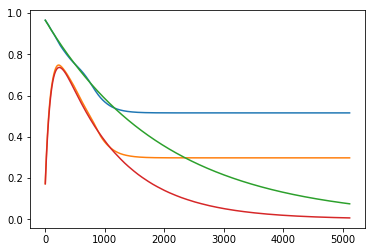

torch.Size([320, 5120, 2])
torch.Size([320, 5120, 2])
tensor(0.0229, dtype=torch.float64)
torch.Size([5120])


/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


tensor(nan, dtype=torch.float64)
torch.Size([5120])


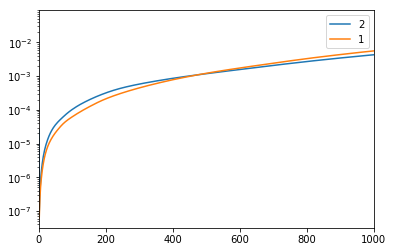

In [11]:
#graph for d1
y_preds_2 = models[1].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=5120)
print(y_preds_2.shape)
plt.plot(y_preds_2[0,:,0].cpu().detach().numpy())
plt.plot(y_preds_2[0,:,1].cpu().detach().numpy())

print(y_preds_2[0,0])

plt.plot(test_data[0,:,0])#.cpu().detach().numpy())
plt.plot(test_data[0,:,1])#.cpu().detach().numpy())
plt.show()
plt.xlim([0,1000])

print((y_preds_2 - test_data[:,1:,:]).shape)

print(((y_preds_2 - test_data[:,1:,:])**2).shape)

mse = torch.mean((y_preds_2 - test_data[:,1:,:])**2, axis = (0,2))
print(torch.mean((y_preds_2 - test_data[:,1:,:])**2))
# mse = np.mean(((y_preds - test_data[:,1:,:])**2))
print(mse.shape)

plt.semilogy(mse, label = "2")


y_preds_1 = models[0].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=5120)
mse = torch.mean((y_preds_1 - test_data[:,1:,:])**2, axis = (0,2))
print(torch.mean((y_preds_1 - test_data[:,1:,:])**2))
# mse = np.mean(((y_preds - test_data[:,1:,:])**2))
print(mse.shape)

plt.semilogy(mse, label = "1")
plt.legend()

In [12]:
y_preds_2 = models[1].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=5120)
y_preds_1 = y_preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


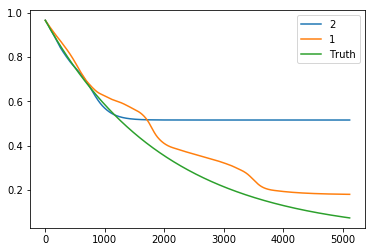

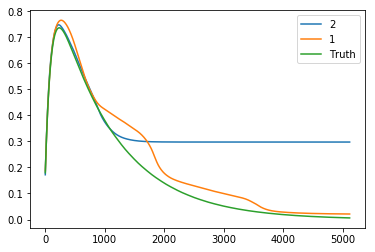

In [19]:
plt.plot(y_preds_2[0,:,0], label = "2")
plt.plot(y_preds_1[0,:,0], label = "1")
plt.plot(test_data[0,1:,0], label = 'Truth')
plt.legend()
plt.show()

plt.plot(y_preds_2[0,:,1], label = "2")
plt.plot(y_preds_1[0,:,1], label = "1")
plt.plot(test_data[0,1:,1], label = 'Truth')
plt.legend()
plt.show()

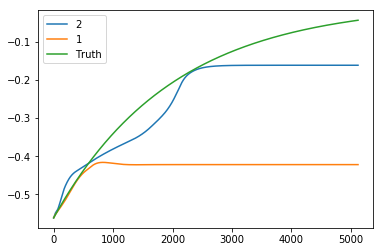

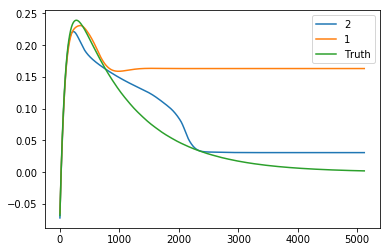

In [22]:
i = 3
plt.plot(y_preds_2[i,:,0], label = "2")
plt.plot(y_preds_1[i,:,0], label = "1")
plt.plot(test_data[i,1:,0], label = 'Truth')
plt.legend()
plt.show()

plt.plot(y_preds_2[i,:,1], label = "2")
plt.plot(y_preds_1[i,:,1], label = "1")
plt.plot(test_data[i,1:,1], label = 'Truth')
plt.legend()
plt.show()

In [ ]:
hello

  0%|          | 0/2 [00:00<?, ?it/s]

/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


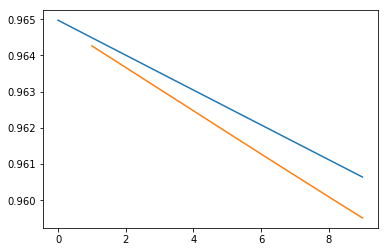

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


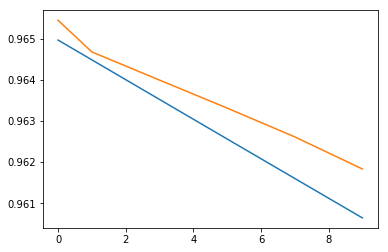

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03]),
 <a list of 8 Text yticklabel objects>)

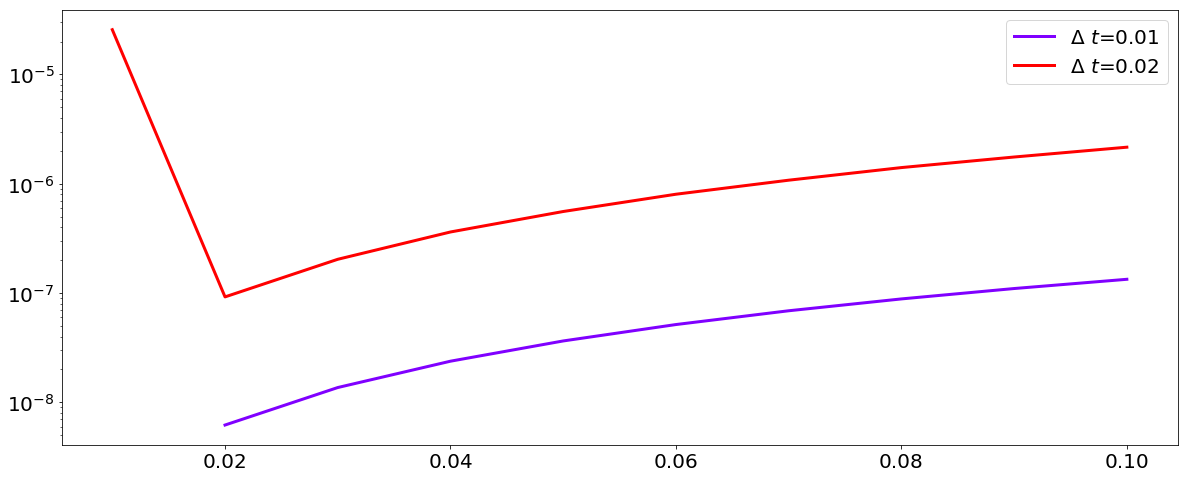

In [74]:
# uniscale time-stepping with NN
import time
# n_steps = test_data.shape[1] - 1
n_steps = 10
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:n_steps+1, :]).float(), y_preds).mean(-1))
    
    plt.plot(test_data[0, 1:n_steps+1, 0])
    plt.plot(y_preds[0,:,0])
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [70]:
test_data.shape

(320, 5121, 2)